In [40]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio
from torch.cuda.amp import autocast, GradScaler


In [2]:
pwd

'/home/ubuntu/Desktop/Pytorch'

In [3]:
#!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

In [4]:
#!unzip -qq -o Food-5K.zip

In [5]:
ls

84_transfer_learning.ipynb  Food-5K/   training/
evaluation/                 __MACOSX/  validation/


In [6]:
#!ls Food-5K/training

ls: cannot access 'Food-5K/training': No such file or directory


In [7]:
#!mv Food-5K/* .

mv: cannot stat 'Food-5K/*': No such file or directory


/tmp/ipykernel_23581/2758008779.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread("training/0_1001.jpg"))


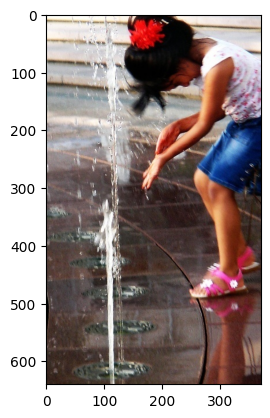

In [10]:
plt.imshow(imageio.imread("training/0_1001.jpg"))

/tmp/ipykernel_23581/3243074545.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread("training/1_1384.jpg"))


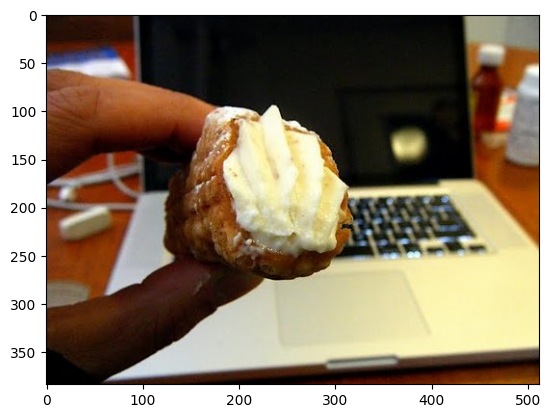

In [11]:
plt.imshow(imageio.imread("training/1_1384.jpg"))

In [12]:
#!mkdir data

In [13]:
# !mkdir data/train
# !mkdir data/test
# !mkdir data/train/nonfood
# !mkdir data/train/food
# !mkdir data/test/nonfood
# !mkdir data/test/food

In [14]:
# #move the images
# !mv training/0*.jpg data/train/nonfood
# !mv training/1*.jpg data/train/food
# !mv validation/0*.jpg data/test/nonfood
# !mv validation/1*.jpg data/test/food

In [16]:
#normalize mean and std are sstandardized for ImageNEt

train_transform=transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                                                                                                                                                                                                                                          
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform=transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),                                                                                                                                                                                                                                                                                              
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])                                                                                                                                                                                      

In [17]:
train_dataset=datasets.ImageFolder(
    "data/train",
    transform=train_transform
)

test_dataset=datasets.ImageFolder(
    "data/test",
    transform=test_transform
)

In [18]:
batch_size=128

train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [19]:
#define model

model=models.vgg16(pretrained=True)

#freeze VGG weights

for param in model.parameters():
    param.requires_grad=False

/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current value

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [23]:
n_features=model.classifier[0].in_features
n_features

25088

In [24]:
#for binary classification
model.classifier=nn.Linear(n_features,2)

In [31]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:
#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [35]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)  

  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for inputs, targets in train_loader:
      #targets=targets.view(-1,1).float()
      inputs, targets=inputs.to(device), targets.to(device)


      #zro the optimizer
      optimizer.zero_grad(set_to_none=True)

      #forward pass
      outputs=model(inputs)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    #get train loss and test loss
    train_loss=np.mean(train_loss)

    test_loss=[]

    for inputs, targets in test_loader:
      #move data to GPU
      inputs, targets=inputs.to(device), targets.to(device)
      #targets=targets.view(-1,1).float()
    
      #forward pass
      outputs=model(inputs)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      test_loss.append(loss.item())
    
    #get train loss and test loss
    test_loss=np.mean(test_loss)

    #save losses
    train_losses[it]=train_loss
    test_losses[it]=test_loss



    print(f"epoch {it+1}/{epochs}, train loss:{train_loss:.4f}",                                                                                                                                                                                                                                                
          f"test loss {test_loss:.4f}")
    
  return train_losses, test_losses



In [36]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, train_loader, test_loader, 5)

epoch 1/5, train loss:0.0710 test loss 0.0159


KeyboardInterrupt: 

In [41]:
def batch_gd2(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    model = nn.DataParallel(model)  # Use data parallelism

    scaler = GradScaler()  # Use mixed-precision training

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Backward and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        print(f"epoch {it+1}/{epochs}, train loss:{train_loss:.4f}",
              f"test loss {test_loss:.4f}")

    return train_losses, test_losses

In [42]:
train_losses, test_losses=batch_gd2(model, criterion, optimizer, train_loader, test_loader, 5)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/ubuntu/.local/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch 1/5, train loss:0.0219 test loss 0.0001
epoch 2/5, train loss:0.0346 test loss 0.0000
epoch 3/5, train loss:0.0231 test loss 0.0001
epoch 4/5, train loss:0.0134 test loss 0.0006
epoch 5/5, train loss:0.0104 test loss 0.0006


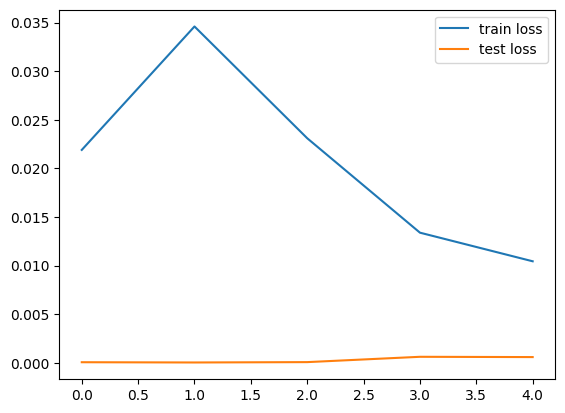

In [43]:
# plot loss per iteration
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [44]:
model = nn.DataParallel(model)  

In [45]:
model

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      